# Data Dive: Unmasking the Secrets of Store Sales

In [1]:
# libraries
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)
sns.set(rc={"figure.figsize":(12,12)}) 

## Business Problem

The business problem entails forecasting sales for various product families sold in Favorita stores situated in Ecuador. The provided training data encompasses crucial details such as dates, store specifics, product information, promotional status of items, and corresponding sales figures. The supplementary files augment this information, offering additional insights that can be leveraged in the construction of predictive models. The key challenge revolves around developing accurate models capable of predicting future sales trends for diverse product categories within Favorita stores, aiding in strategic decision-making and inventory management.

## Dataset Description
<b>store_nbr:</b> Identifies the store where the products are sold.<br>
<b>family:</b> Represents the type of product being sold.<br>
<b>sales:</b> Indicates the total sales for a product family at a specific store on a given date. Fractional values may occur, reflecting the sale of products in fractional units (e.g., 1.5 kg of cheese).<br>
<b>onpromotion:</b> Denotes the total count of items in a product family that were under promotion at a store on a particular date.

In [2]:
train_df = pd.read_csv("./data/raw/train.csv")

In [3]:
train_df.head(10)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0
5,5,2013-01-01,1,BREAD/BAKERY,0.0,0
6,6,2013-01-01,1,CELEBRATION,0.0,0
7,7,2013-01-01,1,CLEANING,0.0,0
8,8,2013-01-01,1,DAIRY,0.0,0
9,9,2013-01-01,1,DELI,0.0,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [5]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.0,750221.75,1500443.5,2.250665e+06,3000887.0
store_nbr,3000888.0,2.750000e+01,15.585787,1.0,14.00,27.5,4.100000e+01,54.0
sales,3000888.0,3.577757e+02,1101.997721,0.0,0.00,11.0,1.958473e+02,124717.0
onpromotion,3000888.0,2.602770e+00,12.218882,0.0,0.00,0.0,0.000000e+00,741.0


In [6]:
train_df.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

The data initially has date information stored as an object type instead of a datetime format. It is advisable to convert this to datetime. <br>
The `id` features appear to be sequential numbers rather than unique identifiers and can be safely removed. Fortunately, there are no missing values in the dataset.

In [7]:
# convert to datetime using pd.to_datetime
train_df['date'] = pd.to_datetime(train_df['date'])

In [8]:
train_df["onpromotion"].value_counts(ascending=False)

0      2389559
1       174551
2        79386
3        45862
4        31659
        ...   
313          1
452          1
642          1
305          1
425          1
Name: onpromotion, Length: 362, dtype: int64

### Data Visualization

The logarithmic scale is often used when dealing with data that spans several orders of magnitude. In the context of big data visualization, using a logarithmic scale on the y-axis can help reveal patterns and details in the data that might not be apparent when using a linear scale.<br>

When you have a wide range of values, including very small and very large ones, a logarithmic scale compresses this range. This can be useful for visualizing data with significant variations across different data points. It allows you to see the relative differences more clearly, especially when you have some extremely high values that might otherwise dominate the visual representation.

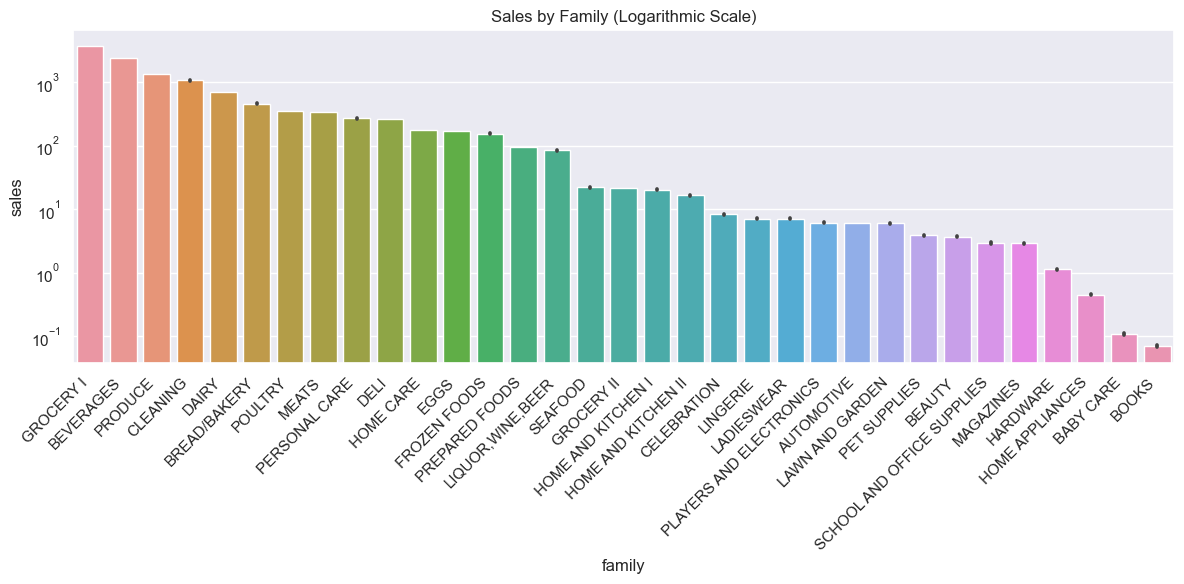

In [9]:
family_order = train_df.groupby('family')['sales'].mean().sort_values(ascending=False).index

# the precomputed order in the bar plot with a logarithmic scale
plt.figure(figsize=(12, 6))
sns.barplot(x='family', y='sales', data=train_df, order=family_order)
plt.yscale('log')  # y-axis to logarithmic scale
plt.title('Sales by Family (Logarithmic Scale)')
plt.xticks(rotation=45, ha='right')  # rotation and alignment
plt.tight_layout()
plt.show()

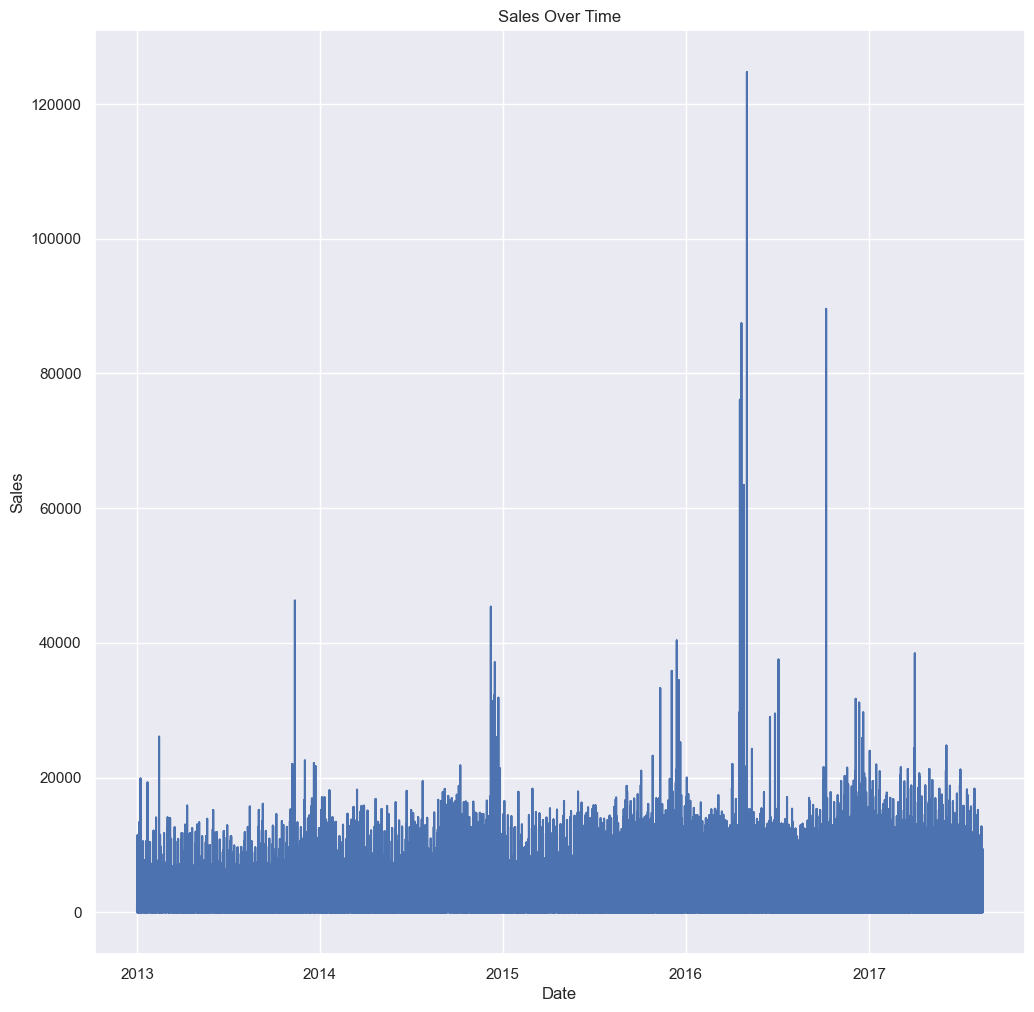

In [10]:
plt.plot(train_df['date'], train_df['sales'])
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In the initial chart, Grocery sales emerge as the highest, followed by Beverages, Produce, Cleaning, and Dairy, with Baby Care and Books experiencing the lowest sales.
<br>

The second chart depicts sales trends over time, revealing notable peaks between 2016 and 2017. Particularly, the first quarter of 2016 stands out with significantly higher sales compared to other periods.<br>

Additionally, a recurring pattern is observable towards the end of each year, with notable sales peaks occurring around December.

In [11]:
families = ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING']
for family in families:
    print(family)

GROCERY I
BEVERAGES
PRODUCE
CLEANING


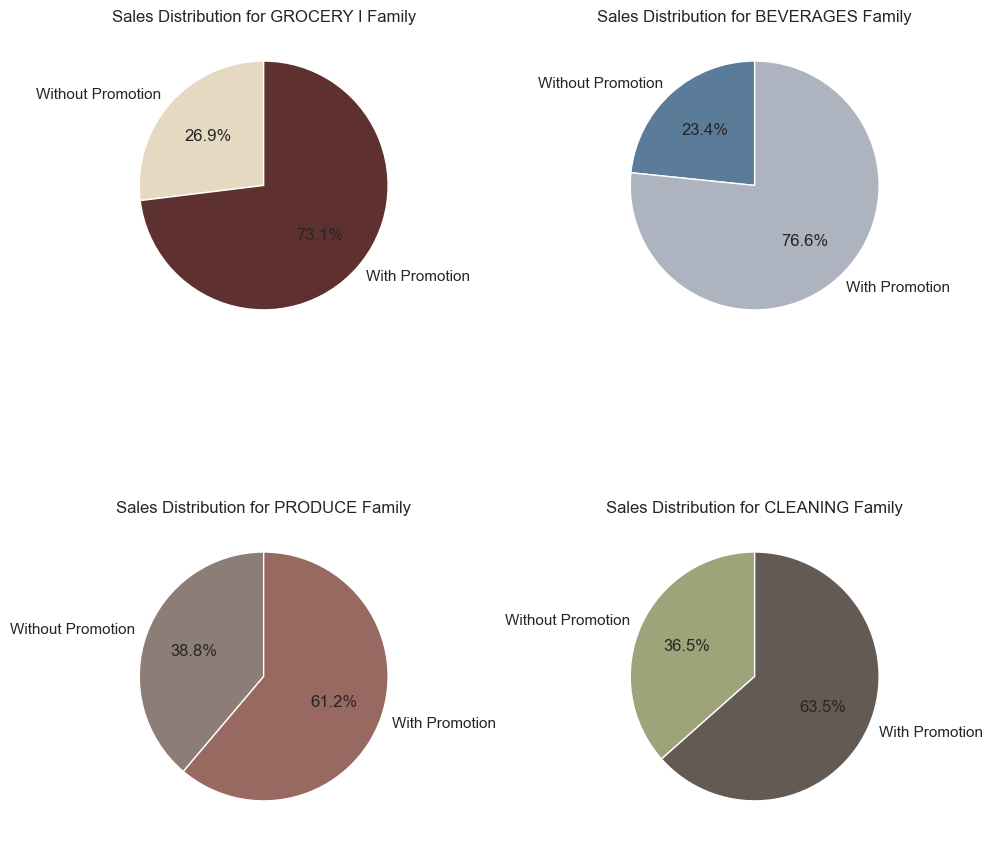

In [12]:
families = ['GROCERY I', 'BEVERAGES', 'PRODUCE', 'CLEANING']
colors = ["#e6d9c2","#5F3030", "#5B7C99", "#ADB4BF", "#8D7D77", "#986960", "#9EA479", "#645A54"]
fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

for i, family in enumerate(families):

    sales_no_promotion = train_df[(train_df['family'] == family) & (train_df['onpromotion'] == 0)]['sales'].sum()
    sales_promotion = train_df[(train_df['family'] == family) & (train_df['onpromotion'] > 0)]['sales'].sum()

    labels = ["Without Promotion", "With Promotion"]
    sales_data = [sales_no_promotion, sales_promotion]

    current_colors = colors[i*2:i*2 + 2]

    axes[i].pie(sales_data, labels=labels, autopct="%1.1f%%", colors=current_colors, startangle=90)
    axes[i].set_title(f"Sales Distribution for {family} Family")


plt.tight_layout()
plt.show()

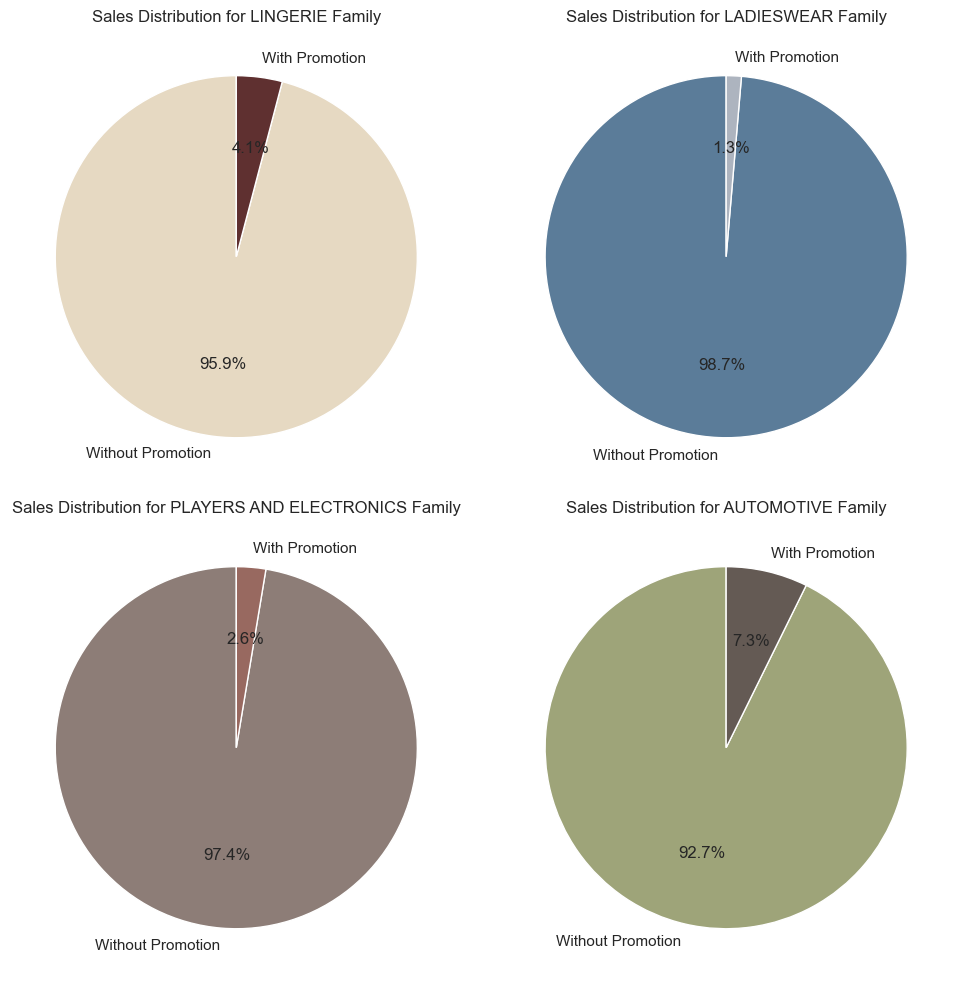

In [13]:
# get the least sold products
family_order = train_df.groupby('family')['sales'].mean().sort_values(ascending=False).index
least_sold_products = family_order[20:24]

colors = ["#e6d9c2","#5F3030", "#5B7C99", "#ADB4BF", "#8D7D77", "#986960", "#9EA479", "#645A54"]
fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

for i, family in enumerate(least_sold_products):

    sales_no_promotion = train_df[(train_df['family'] == family) & (train_df['onpromotion'] == 0)]['sales'].sum()
    sales_promotion = train_df[(train_df['family'] == family) & (train_df['onpromotion'] > 0)]['sales'].sum()

    labels = ["Without Promotion", "With Promotion"]
    sales_data = [sales_no_promotion, sales_promotion]

    current_colors = colors[i*2:i*2 + 2]

    axes[i].pie(sales_data, labels=labels, autopct="%1.1f%%", colors=current_colors, startangle=90)
    axes[i].set_title(f"Sales Distribution for {family} Family")


plt.tight_layout()
plt.show()

Products with the lowest sales figures appear to have minimal or no promotional activities associated with them.

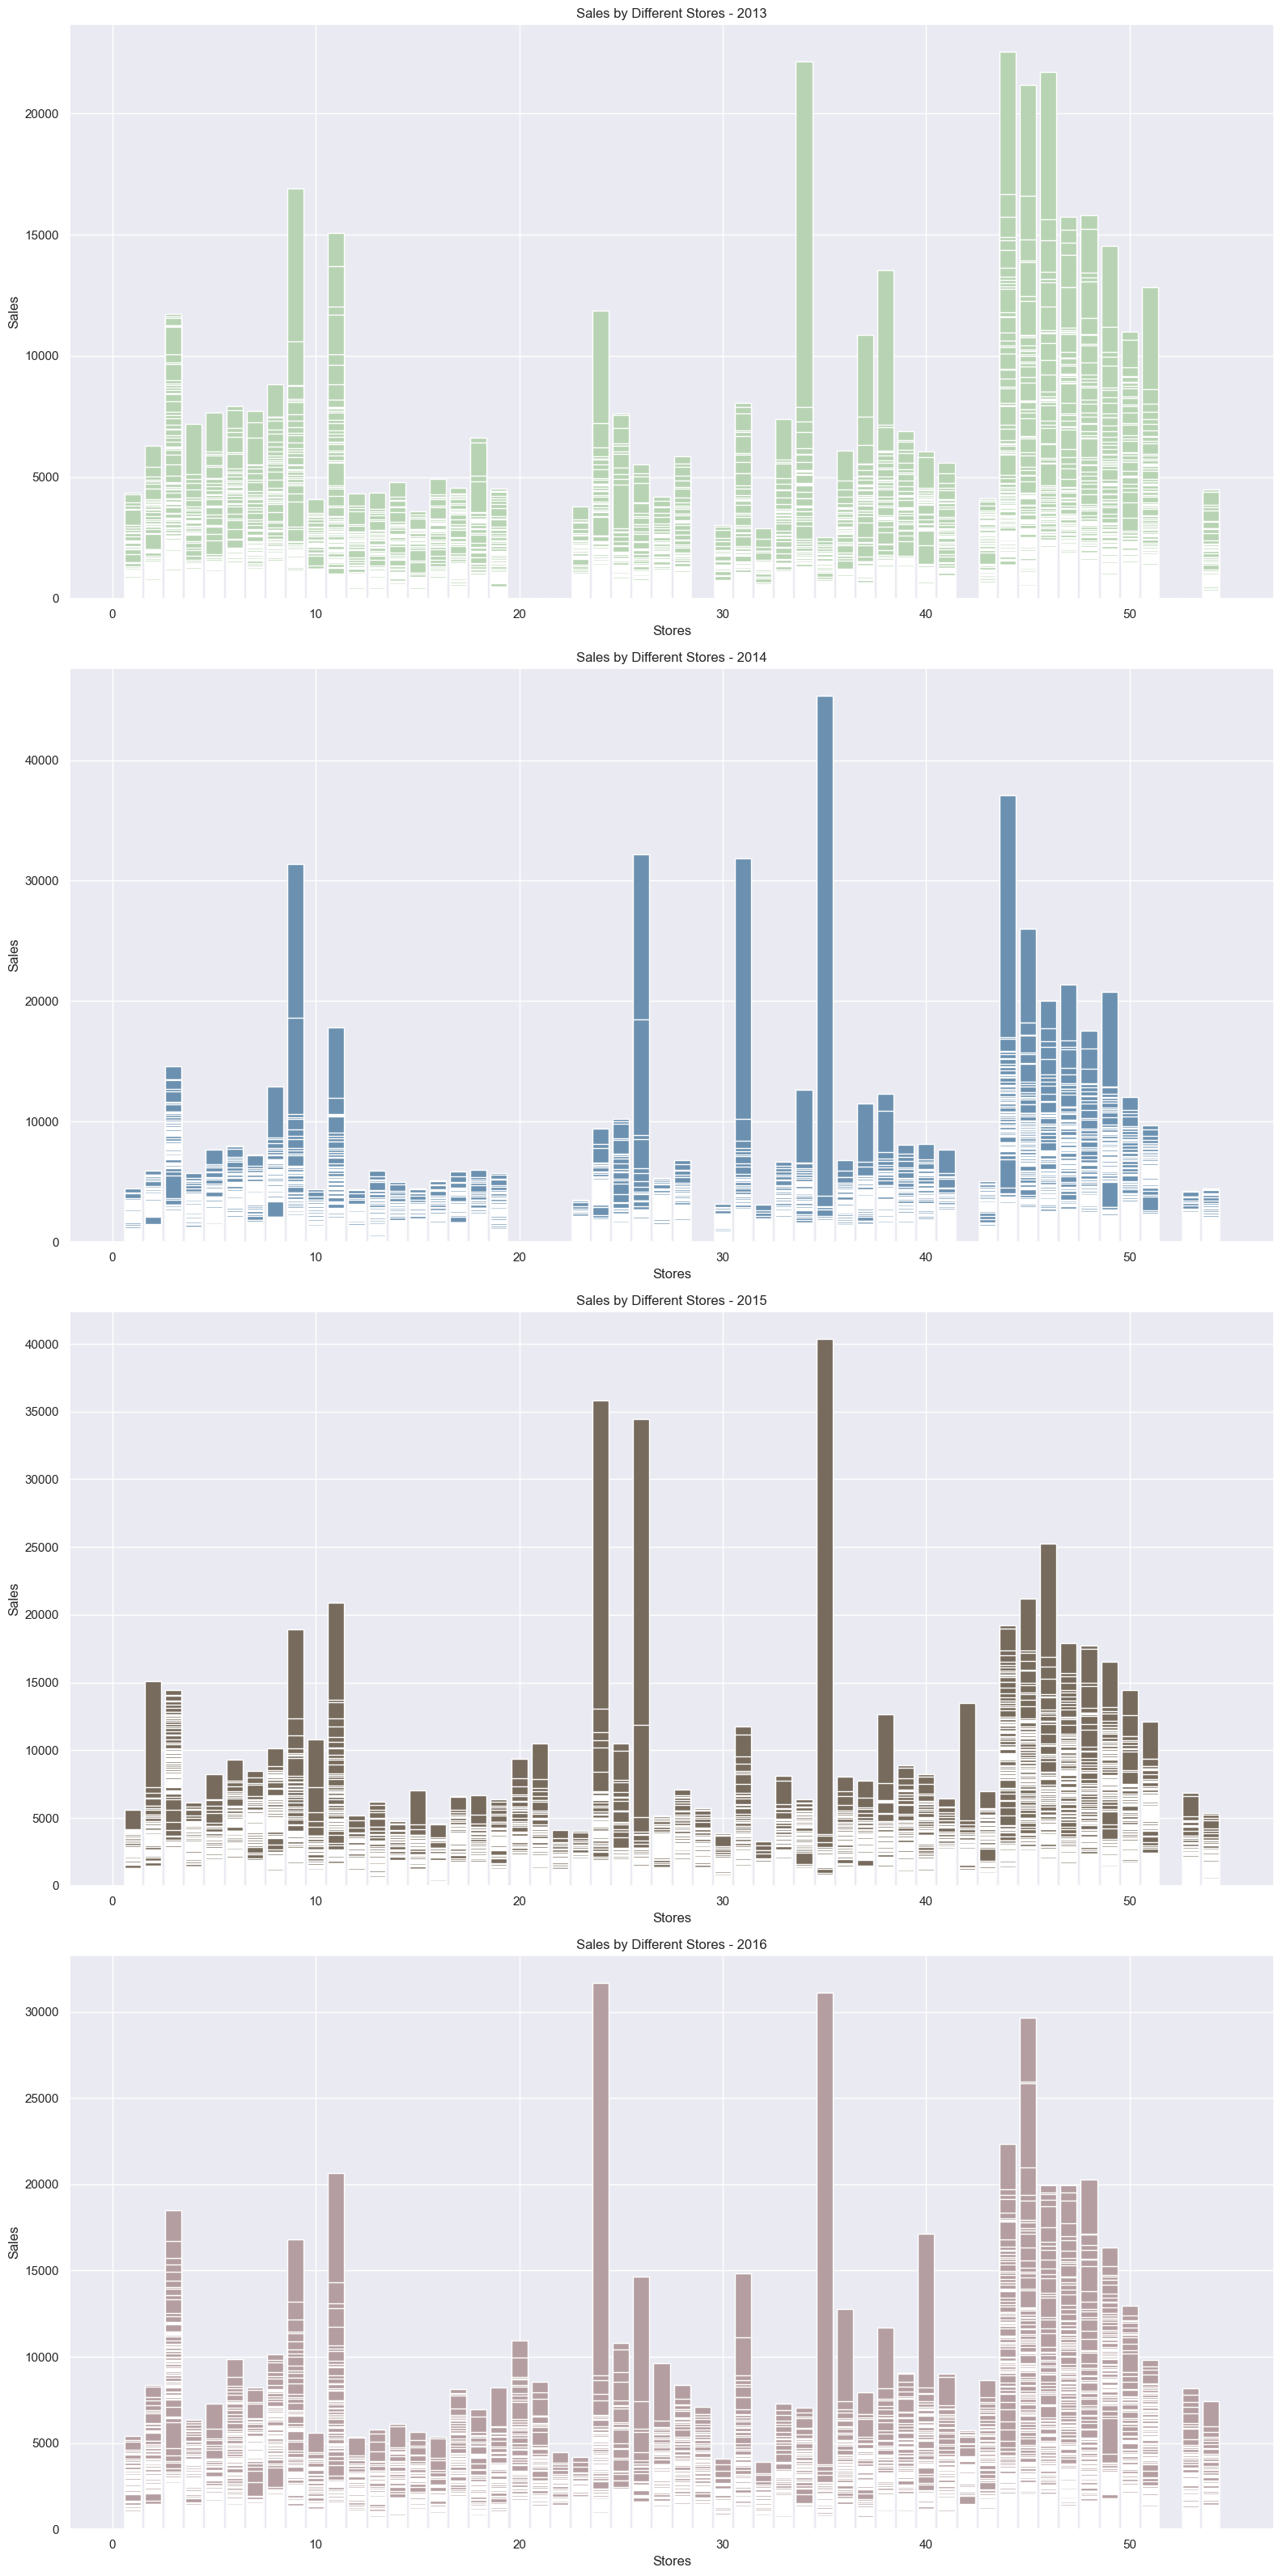

In [14]:
# checking the christmas time for december pattern
years = [2013, 2014, 2015, 2016]
fig, axes = plt.subplots(nrows=4, ncols=1, figsize = (16,4*8))
colors = ["#b7d3b3", "#6c91b0", "#776B5D", "#b59ea1"]

for i, year in enumerate(years):
    start_date = pd.to_datetime(f'{year}-12-01')
    end_date = pd.to_datetime(f'{year}-12-31')
    subset = train_df[train_df['date'].between(start_date, end_date)]
    sorted_data = subset.sort_values(by="sales", ascending=False)

    x_axis_sorted = sorted_data["store_nbr"]
    y_axis_sorted = sorted_data["sales"]

    axes[i].bar(x_axis_sorted, y_axis_sorted, color=colors[i])
    axes[i].set_xlabel("Stores")
    axes[i].set_ylabel("Sales")
    axes[i].set_title(f"Sales by Different Stores - {year}")

plt.tight_layout()
plt.show()

When analyzing the Christmas sales patterns in December for each year, it is observed that in 2013, the 35th and 44th stores exhibited the highest sales. This pattern persisted in 2014 as well.<br>

An intriguing observation is that the sales for the 35th store reached their peak in 2014, surpassing the sales figures for all other years.<br>

However, in 2015, there was a shift, and the 24th and 26th stores emerged with the highest sales, alongside the 35th store. Moving to 2016, the 24th store surpassed the 35th store, claiming the top spot in terms of sales, while the 26th store experienced a decline compared to the previous year.

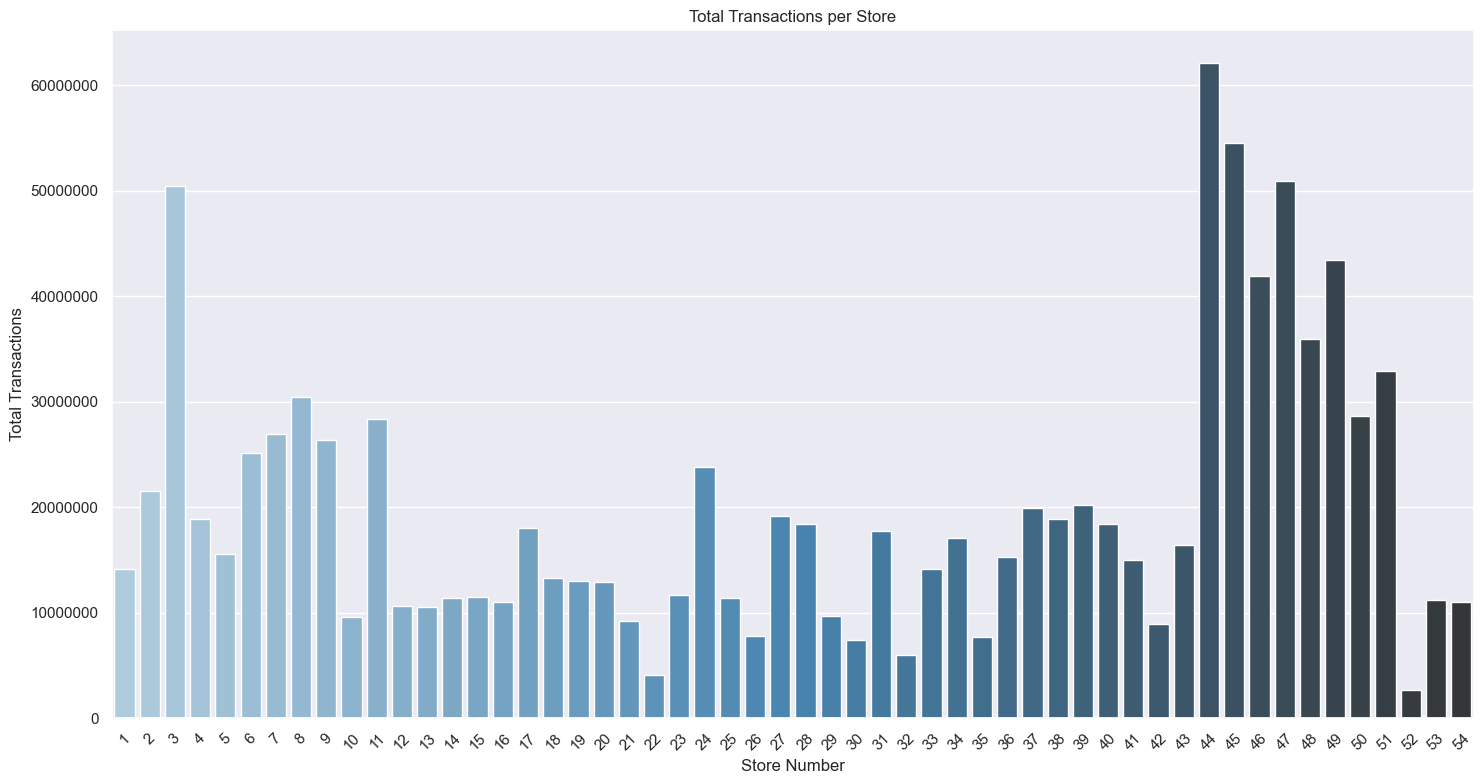

In [15]:
grouped_df = train_df.groupby("store_nbr")["sales"].sum().reset_index()


plt.figure(figsize=(15, 8))
ax = sns.barplot(x='store_nbr', y='sales', data=grouped_df, palette = "Blues_d")
plt.title('Total Transactions per Store')
plt.xlabel('Store Number')
plt.ylabel('Total Transactions')
plt.xticks(rotation=45)  # rotation and alignment
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
plt.show()

Earlier, it was noted that during certain seasons, such as Christmas, sales in the city of Playas surpassed those in Guayaquil or Quito. This trend may be attributed to Playas having an economy centered around tourism. Nevertheless, this also indicates that the variation in seasonal sales does not correspond with the overall sales across the years.<br>